#=====================Diabetics occurance prediction=================


# Data Exploration 

In [1]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import scipy as sp
from xgboost.sklearn import XGBClassifier
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
print(os.getcwd())
os.chdir('gdrive/My Drive/Colab projects/CA1')
!ls

/content
CA1.ipynb  diabetes.csv  diabetic_data.csv  IDs_mapping.csv  temp.ipynb


In [8]:
#loading Dataset
df = pd.read_csv("diabetic_data.csv", na_values='?')
ID = pd.read_csv('IDs_mapping.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
#displaying first 5 rows of data
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [10]:
# Displaying a few rows of ID, ID data gives more information about diabetic data!
ID.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [11]:
#Checking percent of missing values in each column
df.isna().sum()[df.isna().sum()>0]/len(df)

race                 0.022336
weight               0.968585
payer_code           0.395574
medical_specialty    0.490822
diag_1               0.000206
diag_2               0.003518
diag_3               0.013983
dtype: float64

In [0]:
#dropping columns with high missing values
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)

In [0]:
#In ID file you can find that discharge_disposition_id =11 implies the patient is expired, so removing all the rows where patient is expired.
drop_Idx = set(df[df['discharge_disposition_id'] == 11].index)
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

df = df.dropna(how='any')   

In [14]:
# Checking for null values again
df.isna().sum()[df.isna().sum()>0]/len(df)

Series([], dtype: float64)

## Feature Engineering

In [0]:
#Converting the target variable into categories
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

In [16]:
#Checking some columns value counts
some_cat_cols = ['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id','metformin', 'repaglinide',
                 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
                 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
                 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone']
for c in some_cat_cols:
    print("================ %s ==================" % c)
    print(df[c].value_counts())

================ race ==================
Caucasian          73835
AfricanAmerican    18560
Hispanic            1971
Other               1464
Asian                617
Name: race, dtype: int64
================ gender ==================
Female             52006
Male               44440
Unknown/Invalid        1
Name: gender, dtype: int64
================ age ==================
[70-80)     24816
[60-70)     21521
[50-60)     16546
[80-90)     16223
[40-50)      9208
[30-40)      3538
[90-100)     2594
[20-30)      1471
[10-20)       466
[0-10)         64
Name: age, dtype: int64
================ admission_type_id ==================
1    51097
3    18071
2    17300
6     5072
5     4568
8      312
7       17
4       10
Name: admission_type_id, dtype: int64
================ discharge_disposition_id ==================
1     57610
3     13564
6     12626
18     3624
2      2049
22     1970
5      1127
25      941
4       756
7       592
23      400
13      396
14      368
28      137
8       106

In [0]:
#Replacing the Unknown/Invalid values with mode of that column
df = df.replace('Unknown/Invalid',df['gender'].mode()[0])

In [0]:
#Since all the below columns have 'No' value more and have very less or 0, 'Steady', 'Up', 'Down' values.
df = df.drop(['citoglipton', 'examide','acetohexamide','troglitazone','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'], axis = 1)

In [0]:
#Converting the string to categories
df['gender'] = df['gender'].replace('Male', 0)
df['gender'] = df['gender'].replace('Female', 1)

In [20]:
# # Mapping age column from (0-10) - (90-100) to midpoint values
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)

age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)
print(df.age.value_counts())

75    24816
65    21521
55    16546
85    16223
45     9208
35     3538
95     2594
25     1471
15      466
5        64
Name: age, dtype: int64


In [21]:
#Creating a new column numchange, that indicated the no of medicaion changes
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'glipizide-metformin', 'tolbutamide']
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]
    
df['numchange'].value_counts()  

0    70143
1    24922
2     1271
3      106
4        5
Name: numchange, dtype: int64

In [0]:
# For all the colummns that has 'No', 'Steady', 'Up', 'Down' converting them to integers
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

In [0]:
# Mapping the below columns to reduce categories in each column

df['admission_type_id'] = df['admission_type_id'].replace(2,1)
df['admission_type_id'] = df['admission_type_id'].replace(7,1)
df['admission_type_id'] = df['admission_type_id'].replace(6,5)
df['admission_type_id'] = df['admission_type_id'].replace(8,5)

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(6,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(8,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(9,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(13,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(3,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(4,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(5,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(14,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(22,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(23,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(12,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(15,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(16,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(17,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(25,18)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(26,18)

df['admission_source_id'] = df['admission_source_id'].replace(2,1)
df['admission_source_id'] = df['admission_source_id'].replace(3,1)
df['admission_source_id'] = df['admission_source_id'].replace(5,4)
df['admission_source_id'] = df['admission_source_id'].replace(6,4)
df['admission_source_id'] = df['admission_source_id'].replace(10,4)
df['admission_source_id'] = df['admission_source_id'].replace(22,4)
df['admission_source_id'] = df['admission_source_id'].replace(25,4)
df['admission_source_id'] = df['admission_source_id'].replace(15,9)
df['admission_source_id'] = df['admission_source_id'].replace(17,9)
df['admission_source_id'] = df['admission_source_id'].replace(20,9)
df['admission_source_id'] = df['admission_source_id'].replace(21,9)
df['admission_source_id'] = df['admission_source_id'].replace(13,11)
df['admission_source_id'] = df['admission_source_id'].replace(14,11)

In [0]:
#Converting the string to categories
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

In [0]:
#Converting the string to categories
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)

In [26]:
#Creating a new feature nummed, that indicates number of medications
df['nummed'] = 0
for col in keys:
    df['nummed'] = df['nummed'] + df[col]
df['nummed'].value_counts()

1    44593
0    22156
2    20899
3     7448
4     1289
5       57
6        5
Name: nummed, dtype: int64

In [0]:
#Dropping a few more columns
df = df.drop(['number_outpatient', 'number_inpatient', 'number_emergency','diag_1', 'diag_2', 'diag_3'], axis = 1)

In [28]:
df.shape

(96447, 36)

In [0]:
# All the numeric columns
num_cols = ['numchange',
 'nummed',
 'time_in_hospital',
 'num_procedures',
 'num_lab_procedures',
 'number_diagnoses','num_medications']

df[num_cols] = df[num_cols].astype('int64')

In [0]:
# Performing required type conversion on variables
df.encounter_id = df.encounter_id.astype('int64')
df.patient_nbr = df.patient_nbr.astype('int64')
df.diabetesMed = df.diabetesMed.astype('int64')
df.change = df.change.astype('int64')
df.age = df.age.astype('int64')

# All the categorical columns
cat_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
           'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'A1Cresult','gender', 'admission_type_id', 'discharge_disposition_id', \
          'admission_source_id', 'max_glu_serum','race']
df[cat_cols] = df[cat_cols].astype('object')

In [31]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                          int64
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
tolazamide                  object
insulin             

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

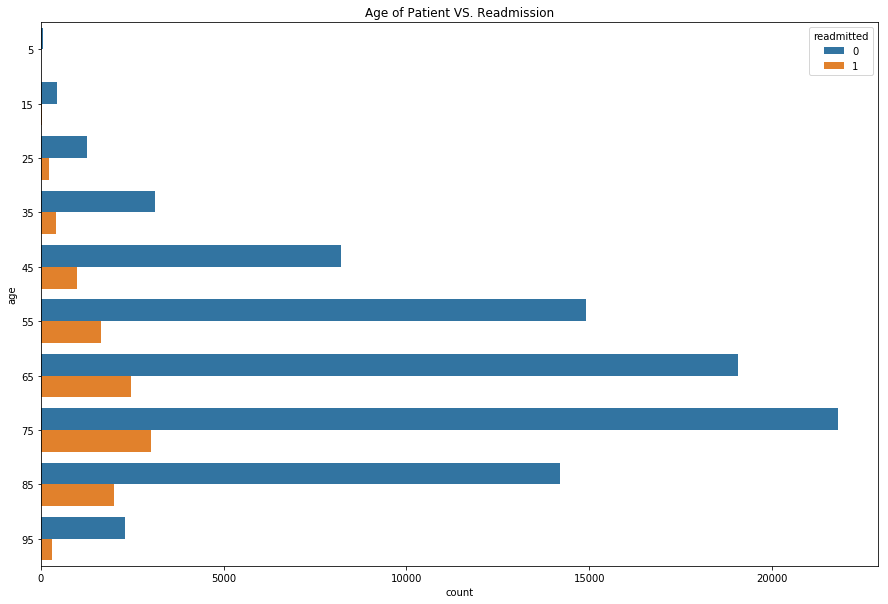

In [32]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= df['age'], hue = df['readmitted']).set_title('Age of Patient VS. Readmission')

### **Pre-modelling**

In [33]:
# dropping multiple encounters while keeping either first or last encounter of these patients
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(67581, 36)

In [0]:
# standardizing the data
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [35]:
df2[num_cols] = standardize(df2[num_cols])
df2 = df2[(np.abs(sp.stats.zscore(df2[num_cols])) < 3).all(axis=1)]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [0]:
correlations = df2.drop(['patient_nbr', 'encounter_id'], axis=1)

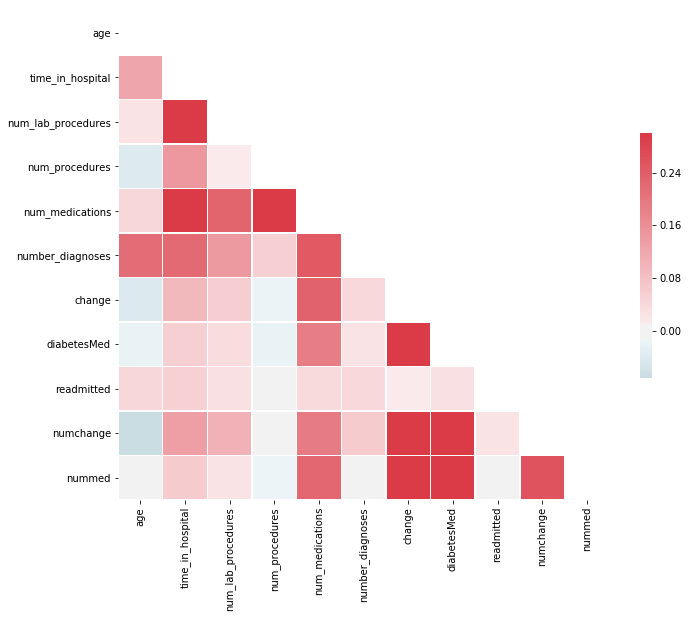

In [37]:
# Compute the correlation matrix
corr = correlations.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
             linewidths=.5, cbar_kws={"shrink": .5},)

In [0]:
# Creating dummy variables for columns more than 2 categories
df_pd = pd.get_dummies(df2, columns=['race', 'admission_type_id', 'discharge_disposition_id',
                                      'admission_source_id', 'max_glu_serum', 'A1Cresult'], drop_first = True)

In [0]:
#Creating a copy of DF
dfcopy = df.copy(deep = True)

## Modeling

In [0]:
X = df_pd.drop('readmitted', axis=1)
y = df_pd['readmitted']

In [0]:
#Splitting the data into Train, Validation and Test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=0)

In [0]:
#Creating a Function to evaluate model performance 
def evaluation (predtr,predval,predte,y_train,y_val,y_test):
    print('\033[1m'+'Train Data :'+'\033[0m')
    print('\033[1m'+'Accuarcy'+'\033[0m', accuracy_score(y_train,predtr))
    print('\033[1m'+'Precision'+'\033[0m', precision_score(y_train,predtr))
    print('\033[1m'+'Recall   '+'\033[0m',recall_score(y_train,predtr))
    print('\033[1m'+'F1_score '+'\033[0m',f1_score(y_train,predtr))
    print('\033[1m'+'Validation Data :'+'\033[0m')
    print('\033[1m'+'Accuarcy'+'\033[0m', accuracy_score(y_val,predval))
    print('\033[1m'+'Precision'+'\033[0m',precision_score(y_val,predval))
    print('\033[1m'+'Recall   '+'\033[0m',recall_score(y_val,predval))
    print('\033[1m'+'F1_score '+'\033[0m',f1_score(y_val,predval))
    print('\033[1m'+'Test Data :'+'\033[0m')
    print('\033[1m'+'Accuarcy'+'\033[0m', accuracy_score(y_test,predte))
    print('\033[1m'+'Precision'+'\033[0m', precision_score(y_test,predte))
    print('\033[1m'+'Recall   '+'\033[0m',recall_score(y_test,predte))
    print('\033[1m'+'F1_score '+'\033[0m',f1_score(y_test,predte))

In [0]:
def ModelResults(model,train_Data, val_Data,test_Data,train_labels,val_labels,test_labels):
  predtr = model.predict(train_Data)
  predval = model.predict(val_Data)
  predte = model.predict(test_Data)
  evaluation(predtr,predval, predte, train_labels,val_labels, test_labels)

### **Decision Tree**

In [44]:
dtree = DecisionTreeClassifier(max_depth=25, criterion = "gini", min_samples_split=10)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [45]:
ModelResults(dtree,X_train, X_val,X_test,y_train,y_val,y_test)

Train Data :
Accuarcy 0.945952274517317
Precision 0.8225501324252743
Recall    0.5122525918944392
F1_score  0.6313343981414259
Validation Data :
Accuarcy 0.8634664093595465
Precision 0.14555765595463138
Recall    0.10171730515191546
F1_score  0.119751166407465
Test Data :
Accuarcy 0.8650809924133689
Precision 0.15372670807453417
Recall    0.11379310344827587
F1_score  0.13077939233817704


### **SMOTE**

In [46]:
#### Although the accuracy is high the low F1-score indicates the class im-balance problem. So, performing SMOTE technique to generate synthetic data points that helps eliminate class imabalance 
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=20)
x_train_smote, y_train_smote = smt.fit_sample(X, y)
print('New dataset shape after smote {}'.format(Counter(y_train_smote)))
x_train_smote = pd.DataFrame(x_train_smote, columns = list(X.columns))

Original dataset shape Counter({0: 59151, 1: 5871})
New dataset shape after smote Counter({0: 59151, 1: 59151})


In [0]:
#Splitting the new data
X_temp, X_test, y_temp, y_test = train_test_split(x_train_smote, y_train_smote, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=0)

### Decision Tree

In [48]:
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=28,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [49]:
#As you can see after SMOTE the F1-score has been increased
ModelResults(dtree,X_train, X_val,X_test,y_train,y_val,y_test)

Train Data :
Accuarcy 0.9748572631973044
Precision 0.9863724853990915
Recall    0.9628830181596358
F1_score  0.9744862220850301
Validation Data :
Accuarcy 0.916998143728454
Precision 0.925036878101113
Recall    0.9087076801475431
F1_score  0.9167995746943115
Test Data :
Accuarcy 0.9136706863518539
Precision 0.924948358962589
Recall    0.901767733273663
F1_score  0.9132109675957398


### Random Forest

In [50]:
rfc = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
ModelResults(rfc,X_train, X_val,X_test,y_train,y_val,y_test)

Train Data :
Accuarcy 0.9568513665293897
Precision 1.0
Recall    0.9134719159119703
F1_score  0.954779537986169
Validation Data :
Accuarcy 0.94822328294882
Precision 0.9983899297423887
Recall    0.8985640890528257
F1_score  0.945850377868682
Test Data :
Accuarcy 0.945790600698749
Precision 0.998998998998999
Recall    0.8932647124636384
F1_score  0.9431777909037212


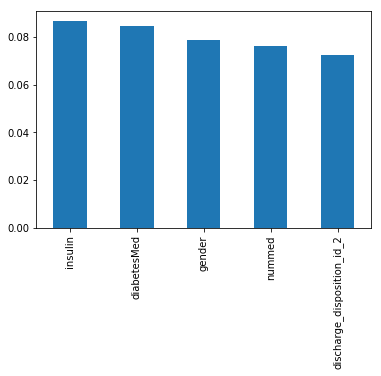

In [52]:
#Displaying the important features
featimp = pd.Series(rfc.feature_importances_,index=X_train.columns).sort_values(ascending=False)
featimp.nlargest(5).plot(kind='bar')

### **XGBoost**

In [0]:
xgb_cf=XGBClassifier()
xgb_cf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
ModelResults(xgb_cf,X_train, X_val,X_test,y_train,y_val,y_test)

Train Data :
Accuarcy 0.9472107824784725
Precision 1.0
Recall    0.8941391769508704
F1_score  0.9441113808650845
Validation Data :
Accuarcy 0.9476266242376028
Precision 1.0
Recall    0.8959293900671849
F1_score  0.9451083935519733
Test Data :
Accuarcy 0.9447762876141103
Precision 1.0
Recall    0.8903557842917879
F1_score  0.941998106060606


### KNN

In [0]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [0]:
ModelResults(knn,X_train, X_val,X_test,y_train,y_val,y_test)

Train Data :
Accuarcy 0.7884336390864845
Precision 0.7435052692162661
Recall    0.8789592229365116
F1_score  0.8055779548215763
Validation Data :
Accuarcy 0.7253381066030231
Precision 0.6885389326334208
Recall    0.8294032406797524
F1_score  0.7524350164326262
Test Data :
Accuarcy 0.7314324354784176
Precision 0.6957215237380372
Recall    0.8296039382412173
F1_score  0.7567870994080425


### ***The model with best performance is Random Forest***